In [ ]:
!pip install -r requirements.txt

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add, Dropout, Resizing
from tensorflow.keras import layers, regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2



from tensorflow.keras import layers
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Competition Navires 2023 à la mano
## SCIA
#### Mohamed Amine El Maghraoui
#### Paul Copigneaux

### Générer le dataset

In [2]:
directory = "dataset/ships_16x24_10cat/data"


On uilise ici ImageDataGenerator pour préparer nos données. Pour l'ensemble d'entraînement, on met à l'échelle les valeurs de pixels et on applique un retournement horizontal pour augmenter la diversité des données. Pour l'ensemble de validation, on met seulement à l'échelle les valeurs de pixels. Dans les deux cas, on réserve 10% des données pour la validation.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,  
    validation_split=0.1  
)

val_datagen = ImageDataGenerator(
    rescale=1./255,  # Mise à l'échelle des valeurs de pixels entre 0 et 1
    validation_split=0.1  # Utiliser validation_split=0.1 pour définir la fraction de données de validation
)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Ici, on prépare les ensembles de données pour l'entraînement et la validation. On ajuste la taille du batch en fonction du nombre de GPUs disponibles. Les images sont mélangées et divisées en sous-ensembles pour l'entraînement et la validation.

In [5]:

batch_size = 64 * len(tf.config.list_physical_devices('GPU')) # ajuster la taille de lot pour chaque GPU

# Chargement et prétraitement des données d'entraînement à partir du dossier "train"
train_dataset = train_datagen.flow_from_directory(
    directory,
    target_size=(16, 24),  # Redimensionnement des images en 16x24 pixels
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset="training",
)

# Chargement et prétraitement des données de validation à partir du dossier "val"
val_dataset = val_datagen.flow_from_directory(
    directory,
    target_size=(16, 24),  # Redimensionnement des images en 16x24 pixels
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset="validation"
)

Found 31968 images belonging to 10 classes.
Found 3547 images belonging to 10 classes.


Dans ce code, on a construit notre modèle final suite à plusieurs expérimentations pour trouver les hyperparamètres optimaux et le bon design d'architecture. On a opté pour un modèle séquentiel utilisant une structure de réseau de neurones convolutif profond. Cela inclut quatre blocs de couches Conv2D, chacun suivi d'une Batch Normalization et d'une MaxPooling2D. Pour prévenir l'overfitting, nous avons également intégré du Dropout après chaque bloc. Finalement, les sorties sont aplaties et passées à une couche Dense avant la prédiction finale via une activation softmax. L'optimiseur Adam a été choisi avec un taux d'apprentissage de 0.001.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Resizing

strategy = tf.distribute.MirroredStrategy()

# Utilisation de la stratégie pour distribuer l'entraînement du modèle sur plusieurs GPU
with strategy.scope():
    model = Sequential()
    model.add(Resizing(32, 32, interpolation='bilinear', input_shape=(16, 24, 3))) 
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75)) # Ajout de Dropout pour la régularisation

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75)) # Ajout de Dropout pour la régularisation
    
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75)) # Ajout de Dropout pour la régularisation
    
    model.add(Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.75)) # Ajout de Dropout pour la régularisation

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001))) # Ajout de Regularisation L2
    model.add(BatchNormalization()) # Ajout de BatchNormalization
    model.add(Dropout(0.9)) # Ajout de Dropout pour la régularisation

    model.add(Dense(10, activation='softmax'))

    # Compilation du modèle avec un taux d'apprentissage adaptatif (Adam)
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])





Ce morceau de code est utilisé pour configurer l'entraînement de notre modèle. Avant de commencer l'entraînement, on imprime le nombre de couches dans notre modèle pour une confirmation visuelle de sa profondeur.

Pour aider le modèle à atteindre une meilleure performance, on a mis en place deux callbacks :

EarlyStopping : Il surveille la précision de la validation (val_accuracy) et arrête l'entraînement si elle ne s'améliore pas après 10 époques (défini par la patience). Cela aide à éviter le surapprentissage. De plus, l'argument restore_best_weights est défini sur True pour que les meilleurs poids (ceux qui ont donné la meilleure val_accuracy) soient restaurés à la fin de l'entraînement.

ReduceLROnPlateau : Il surveille la perte de validation (val_loss) et réduit le taux d'apprentissage par un facteur de 0,1 si celle-ci ne s'améliore pas après 5 époques. Cela permet d'ajuster dynamiquement le taux d'apprentissage pendant l'entraînement et favorise la convergence du modèle.

Enfin, l'entraînement du modèle est lancé en utilisant la méthode fit(), en lui passant les jeux de données d'entraînement et de validation, le nombre d'époques, ainsi que les callbacks précédemment définis.


In [7]:


print("Nombre de couches : ", len(model.layers))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
from keras.callbacks import ReduceLROnPlateau

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])


Nombre de couches :  30
Epoch 1/10


2023-05-29 22:33:06.306173: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 140s 243ms/step - loss: 12.5021 - accuracy: 0.1795 - val_loss: 9.9491 - val_accuracy: 0.2506
Epoch 2/10
500/500 [==============================] - 70s 140ms/step - loss: 8.3424 - accuracy: 0.2759 - val_loss: 6.8110 - val_accuracy: 0.2078
Epoch 3/10
500/500 [==============================] - 70s 139ms/step - loss: 5.5187 - accuracy: 0.3386 - val_loss: 5.4319 - val_accuracy: 0.2441
Epoch 4/10
500/500 [==============================] - 70s 140ms/step - loss: 4.7118 - accuracy: 0.3883 - val_loss: 4.9801 - val_accuracy: 0.3090
Epoch 5/10
500/500 [==============================] - 70s 140ms/step - loss: 3.9768 - accuracy: 0.4391 - val_loss: 3.6346 - val_accuracy: 0.4739
Epoch 6/10
500/500 [==============================] - 70s 140ms/step - loss: 3.6603 - accuracy: 0.4707 - val_loss: 3.3683 - val_accuracy: 0.5199
Epoch 7/10
500/500 [==============================] - 69s 139ms/step - loss: 3.5785 - accuracy: 0.4847 - val_loss: 4.0060 - val_accuracy: 0

In [8]:
epochs = 100
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[reduce_lr_on_plateau, early_stopping])

Epoch 1/100
500/500 [==============================] - 71s 142ms/step - loss: 3.9741 - accuracy: 0.4805 - val_loss: 3.9527 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 97s 193ms/step - loss: 4.3555 - accuracy: 0.4694 - val_loss: 4.1825 - val_accuracy: 0.4485 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 102s 203ms/step - loss: 4.3788 - accuracy: 0.4614 - val_loss: 4.0009 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 70s 140ms/step - loss: 4.2189 - accuracy: 0.4671 - val_loss: 4.0172 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 70s 139ms/step - loss: 4.0087 - accuracy: 0.4697 - val_loss: 4.4341 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - ETA: 0s - loss: 4.1433 - accuracy: 0.4641
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
500/500 [=====================

In [9]:
X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [10]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
print(df[df["Category"] > 1])
df.to_csv("reco_nav.csv", index_label="Id")

116/116 [==============================] - 5s 33ms/step
      Category
0            3
1            8
2            2
3            7
4            3
...        ...
3693         3
3694         5
3695         3
3696         3
3697         5

[2602 rows x 1 columns]


In [11]:
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [12]:
tf.saved_model.save(model, '/kaggle/working/model')  # Save the model in SavedModel format
model.save('/kaggle/working/model_file.h5')
FileLink(r'model_file.h5')

/kaggle/working/model_file.h5

Ce script utilise Matplotlib pour tracer l'évolution de la perte (loss) et de la précision (accuracy) lors de l'entraînement et de la validation du modèle à travers les époques.

1. **Training Loss** : Il s'agit de la perte calculée sur le jeu de données d'entraînement à chaque époque. Une diminution constante de cette courbe indique que le modèle apprend bien.

2. **Validation Loss** : Il s'agit de la perte calculée sur le jeu de données de validation à chaque époque. Si cette courbe commence à augmenter alors que la perte d'entraînement continue de diminuer, cela pourrait être un signe de surajustement.

3. **Training Accuracy** : Il s'agit de la précision calculée sur le jeu de données d'entraînement à chaque époque. Une augmentation constante de cette courbe indique que le modèle apprend bien.

4. **Validation Accuracy** : Il s'agit de la précision calculée sur le jeu de données de validation à chaque époque. Si cette courbe commence à diminuer alors que la précision d'entraînement continue d'augmenter, cela pourrait être un signe de surajustement.


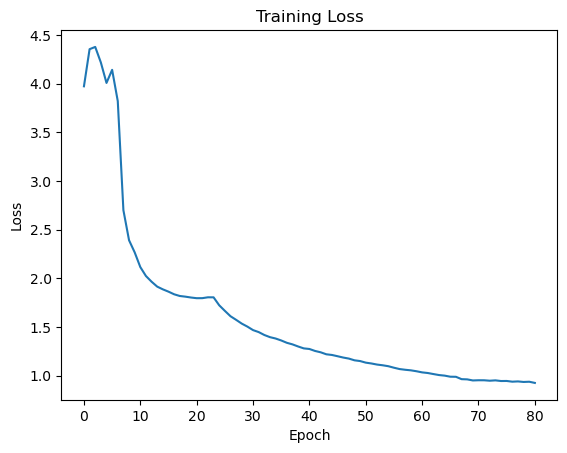

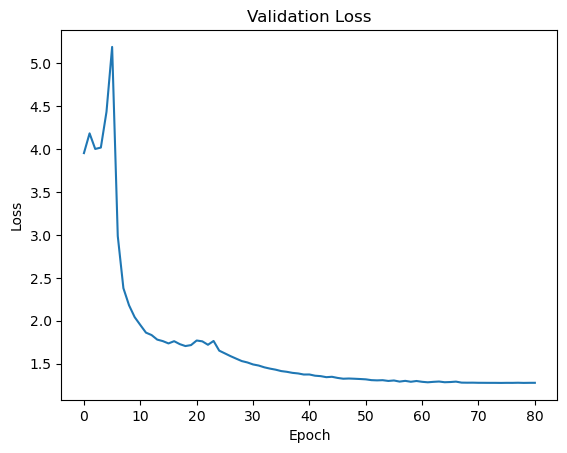

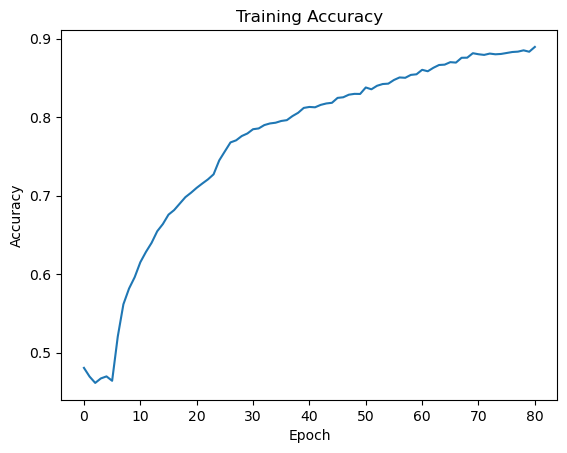

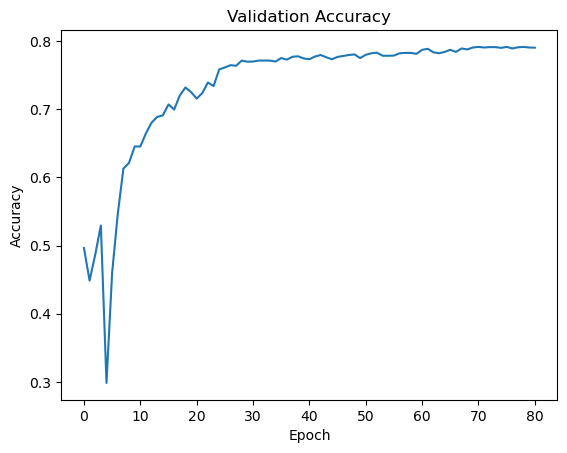

In [13]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Ce code produit une matrice de confusion pour notre modèle de classification. 

1. Il extrait d'abord les étiquettes réelles et prédites de notre jeu de données de validation. 
2. Ensuite, il utilise ces étiquettes pour calculer la matrice de confusion. 
3. Enfin, il utilise Seaborn pour visualiser cette matrice, nous permettant d'évaluer rapidement les performances du modèle.

56/56 [==============================] - 5s 63ms/step


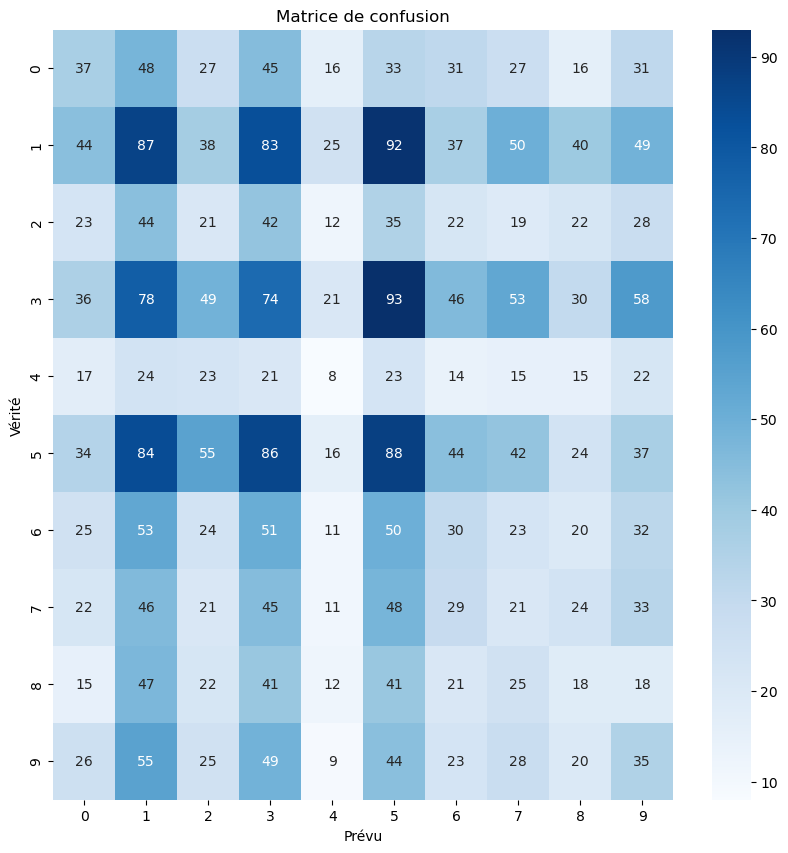

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = val_dataset.classes
predictions = model.predict(val_dataset)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prévu')
plt.ylabel('Vérité')
plt.show()
